# Appendix: Numerical Optimization

This notebook uses the *Optim* package which has general-purpose optimization routines.

## Load Packages

In [1]:
using Optim

#using Dates            #Julia 0.7
using Compat, Missings  #to use 0.7 syntax in 0.6

include("printmat.jl")

printlnPs (generic function with 2 methods)

In [2]:
using Plots
backend = "gr"              #"gr" (default), "pyplot" 

if backend == "pyplot"
    pyplot(size=(600,400))
else    
    gr(size=(600,400))
end

Plots.GRBackend()

# Unconstrained Optimization

In the example below, we want to choose $(x,y)$ so as to minimize the fairly simple objective function

$
(x-2)^2 + (4y+3)^2,  
$

without any constraints. (Yes, the solution should be $(x,y)=(2,-3/4)$.)


In the next few cells, we 

(1) define the loss function and calculate its value on a grid of (x,y) values

(2) plot the contours of the loss function (and then also the surface)

(3) do a numerical minimization to find the optimal values

In [3]:
function lossfun(p::Vector)
    (x,y) = (p[1],p[2])          #unpack the choice variables to write
    L     = (x-2)^2 + (4*y+3)^2  #the loss function on an easy-to-read form
    return L
end

lossfun (generic function with 1 method)

In [4]:
nx = 2*41
ny = 2*61
x = linspace(1,4.5,nx)                 
y = linspace(-1,-0.3,ny)
#x = range(1,stop=4.5,length=nx)   in 0.7
#y = range(-1,stop=-0.3,length=ny)

loss2d = fill(NaN,(nx,ny))      #matrix with loss fn values
for i = 1:nx, j = 1:ny                   
    loss2d[i,j] = lossfun([x[i];y[j]])
end

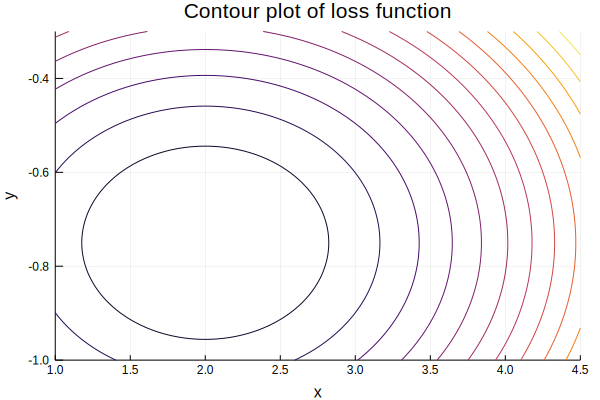

In [5]:
contour(x,y,loss2d',legend=false)         #notice the transpose: loss2d'
title!("Contour plot of loss function")
xlabel!("x")
ylabel!("y")

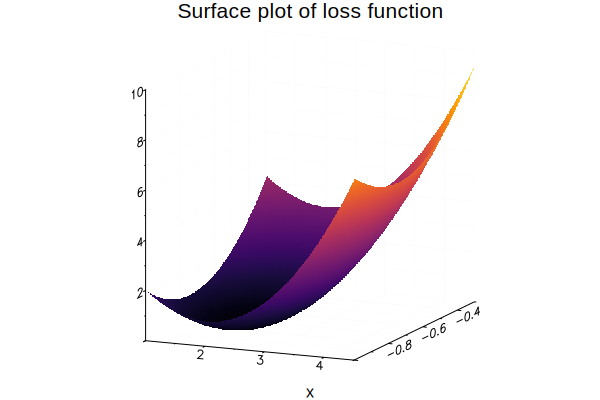

In [6]:
surface(x,y,loss2d',legend=false,zlims=(0,10))   
title!("Surface plot of loss function")
xlabel!("x")

In [7]:
Sol = optimize(p->lossfun(p),[0.0;0.0])

printlnPs("minimum at (x,y)= ",Optim.minimizer(Sol))

minimum at (x,y)=      2.000    -0.750


# Optimization with Equality Constraints

We now impose the constraint that 

$
x+2y-3=0.
$

This clearly means that $x=3-2y$. (Yes, the solution should be $(x,y)=(4,-0.5)$.)

We do this by adding a penalty term $\lambda(x+2y-3)^2$ to the loss function. 


In the next few cells, we 

1. Plot the loss function together with the constraint
    
2. redefine the loss function to also include a penalty for violating the constraint

3. solve for and and plot the optimal values as we impose a higher and higher penalty ($\lambda$) on violating the constraint, starting from $\lambda=0$ and then using the solution as the starting guess for the next iteration.

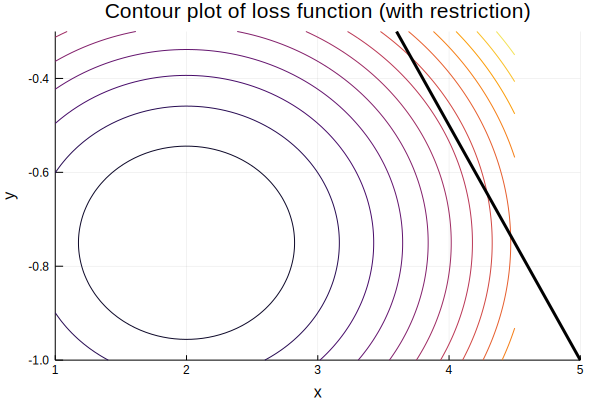

In [8]:
contour(x,y,loss2d',legend=false) 
plot!(3-2*y,y,color=:black,linewidth=3)
title!("Contour plot of loss function (with restriction)")
xlabel!("x")
ylabel!("y")

In [9]:
function lossfun2(p::Vector,lambda)
    (x,y) = (p[1],p[2])          #unpack the choice variables    
    L1 = (x-2)^2 + (4*y+3)^2
    c  = x + 2*y - 3             #equality restriction
    L  = L1 + lambda*c^2
  return L
end

lossfun2 (generic function with 1 method)

In [10]:
println("\nRestricted minima")
println("iteration,    lambda,     solution")
Δpar = Inf
par0 = [0.0;0.0]
parM = fill(NaN,(500,2))
i = 1
while maximum(abs.(Δpar)) > 1e-3
    global Δpar, i, par0
    local λ, Sol, par1
    λ    = i-1
    Sol  = optimize(par->lossfun2(par,λ),par0)
    par1 = Optim.minimizer(Sol)
    printlnPs(i,λ,par1)
    parM[i,:] = par1                 #store in array
    Δpar      = par1 - par0          #change in parameter values
    par0      = copy(par1)           #starting guess in next iteration
    i         = i + 1
end

println("\nCompare with the contour plot above")


Restricted minima
iteration,    lambda,     solution
         1         0     2.000    -0.750
         2         1     3.111    -0.611
         3         2     3.429    -0.571
         4         3     3.579    -0.553
         5         4     3.667    -0.542
         6         5     3.724    -0.534
         7         6     3.765    -0.529
         8         7     3.795    -0.526
         9         8     3.818    -0.523
        10         9     3.837    -0.520
        11        10     3.852    -0.519
        12        11     3.864    -0.517
        13        12     3.875    -0.516
        14        13     3.884    -0.515
        15        14     3.892    -0.514
        16        15     3.899    -0.513
        17        16     3.905    -0.512
        18        17     3.910    -0.511
        19        18     3.915    -0.511
        20        19     3.919    -0.510
        21        20     3.923    -0.510
        22        21     3.927    -0.509
        23        22     3.930    -0.509
   

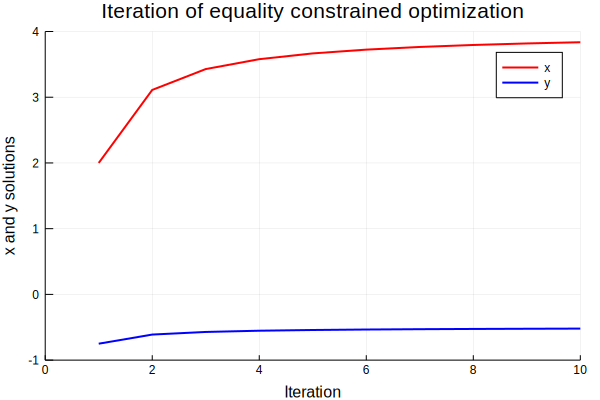

In [11]:
plot(1:10,parM[1:10,1],color=:red,linewidth=2,label="x",xlim=(0,10),ylim=(-1,4))
plot!(1:10,parM[1:10,2],color=:blue,linewidth=2,label="y")
title!("Iteration of equality constrained optimization")
xlabel!("Iteration")
ylabel!("x and y solutions")

# Optimization with Inequality Constraints

We now impose the constraint that $x \ge 3$, by defining

$
r = -(x-3)
$,

and adding a penalty term $\rho \max(0,r)^2$ to the loss function and then iterate (higher and higher $\rho$, using the previous solution as the starting guess).

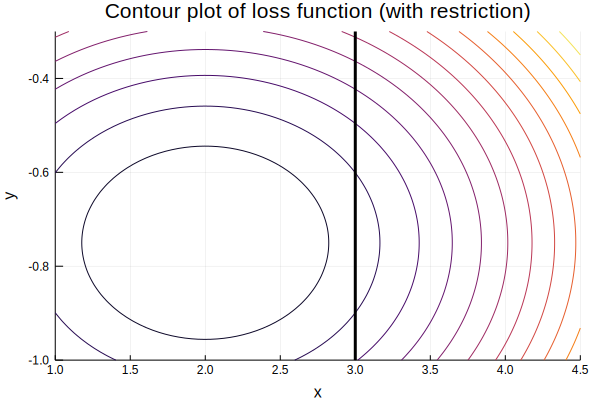

In [12]:
contour(x,y,loss2d',legend=false) 
plot!([3,3],[-1,-0.3],color=:black,linewidth=3)
title!("Contour plot of loss function (with restriction)")
xlabel!("x")
ylabel!("y")

In [13]:
function lossfun3(p::Vector,rho)
    (x,y) = (p[1],p[2])          #unpack the choice variables    
    L1 = (x-2)^2 + (4*y+3)^2
    r  = -(x-3)                  #inequality restriction, <=
    L  = L1 + rho*max(0,r)^2
  return L
end

lossfun3 (generic function with 1 method)

In [14]:
println("\nRestricted optima")
println("interation, rho and solution")
Δpar = Inf
par0 = [0.0;0.0]
parMb = fill(NaN,(500,2))
i = 1
while maximum(abs.(Δpar)) > 1e-3
    global Δpar, i, par0
    local ρ, Sol, par1
    ρ    = i-1
    Sol  = optimize(par->lossfun3(par,ρ),par0)
    par1 = Optim.minimizer(Sol)
    printlnPs(i,ρ,par1)
    parMb[i,:] = par1
    Δpar       = par1 - par0
    par0       = copy(par1)
    i          = i + 1
end


Restricted optima
interation, rho and solution
         1         0     2.000    -0.750
         2         1     2.500    -0.750
         3         2     2.667    -0.750
         4         3     2.750    -0.750
         5         4     2.800    -0.750
         6         5     2.833    -0.750
         7         6     2.857    -0.750
         8         7     2.875    -0.750
         9         8     2.889    -0.750
        10         9     2.900    -0.750
        11        10     2.909    -0.750
        12        11     2.917    -0.750
        13        12     2.923    -0.750
        14        13     2.929    -0.750
        15        14     2.933    -0.750
        16        15     2.937    -0.750
        17        16     2.941    -0.750
        18        17     2.944    -0.750
        19        18     2.947    -0.750
        20        19     2.950    -0.750
        21        20     2.952    -0.750
        22        21     2.955    -0.750
        23        22     2.957    -0.750
        2

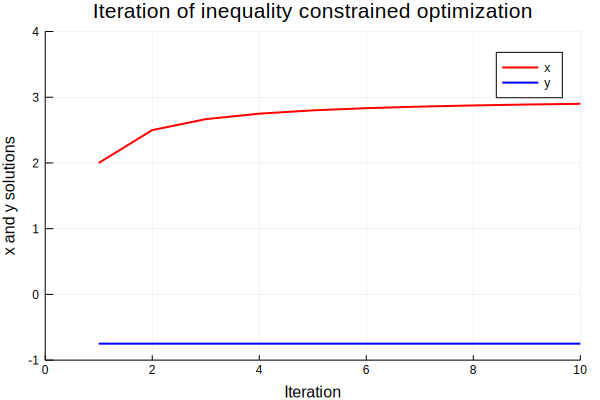

In [15]:
plot(1:10,parMb[1:10,1],color=:red,linewidth=2,label="x",xlim=(0,10),ylim=(-1,4))
plot!(1:10,parMb[1:10,2],color=:blue,linewidth=2,label="y")
title!("Iteration of inequality constrained optimization")
xlabel!("Iteration")
ylabel!("x and y solutions")